# EOSC 573 - Final Project - Cross-section analysis of CTD Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

import gsw

#import cmocean

In [2]:
df = pd.read_csv('CTDcrosssection.csv',index_col=0)
df;

In [3]:
#lets add a density column
df['density']=gsw.density.rho_t_exact(df.salinity, df.temperature, df.pressure)
df

,transect,station,lat,lon,depth,temperature,salinity,pressure,seadepth,density
0,T1,S1,49.3184,-123.1458,24.5,7.476265,26.929817,0.75,0.860874,1020.915827
1,T1,S1,49.3184,-123.1458,24.5,7.471885,26.951505,1.25,1.152643,1020.935632
2,T1,S1,49.3184,-123.1458,24.5,7.477582,27.102969,1.75,1.707756,1021.055558
3,T1,S1,49.3184,-123.1458,24.5,7.493525,27.275464,2.25,2.262577,1021.190627
4,T1,S1,49.3184,-123.1458,24.5,7.476950,27.353243,2.75,2.745438,1021.255783
...,...,...,...,...,...,...,...,...,...,...
1712,T2b,S5,49.3122,-123.1721,28.9,8.223764,29.298585,24.75,24.574700,1022.776695
1713,T2b,S5,49.3122,-123.1721,28.9,8.234730,29.318648,25.25,25.074019,1022.793110
1714,T2b,S5,49.3122,-123.1721,28.9,8.242642,29.322720,25.75,25.561849,1022.797482
1715,T2b,S5,49.3122,-123.1721,28.9,8.243155,29.333838,26.25,26.028045,1022.808378


In [4]:
#speration indext between each transect, defined as the index of the first value in each transect
sep = [0,564,1209,1769,2599,2798]

### Temperature and Salinity Profiles

In [5]:
Dmin = 1020.9
Dmax = 1023.4

levels = np.linspace(Dmin,Dmax, 21)
levels

array([1020.9  , 1021.025, 1021.15 , 1021.275, 1021.4  , 1021.525,
       1021.65 , 1021.775, 1021.9  , 1022.025, 1022.15 , 1022.275,
       1022.4  , 1022.525, 1022.65 , 1022.775, 1022.9  , 1023.025,
       1023.15 , 1023.275, 1023.4  ])

#### Transect 5

In [6]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T5']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T5']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T5']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T5']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T5']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T5']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T5']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T5']))

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


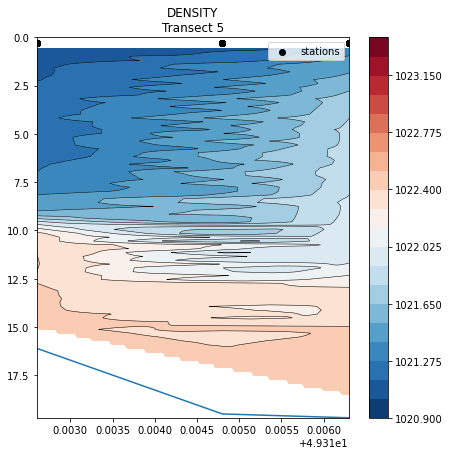

In [7]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

# #SALINITY
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect 5')

# #TEMPERATURE
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect 5')

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="RdBu_r")
plt.colorbar(boundaries=np.linspace(Dmin, Dmax, 21))
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('DENSITY\nTransect 5')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

#### Transect 1

In [8]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T1']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T1']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T1']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T1']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T1']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T1']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T1']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T1']))

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


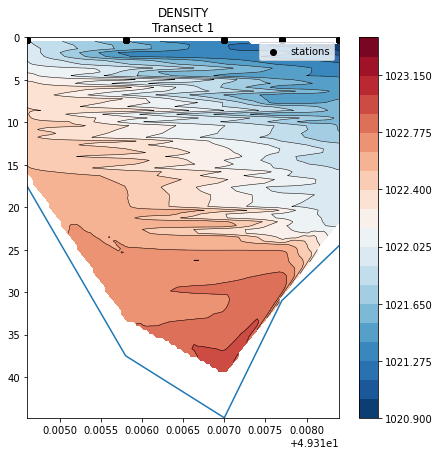

In [9]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)


#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="RdBu_r")
plt.colorbar(boundaries=np.linspace(Dmin, Dmax, 21))
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('DENSITY\nTransect 1')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

# #SALINITY
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect1')

# #TEMPERATURE

# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect1')

#### Transect 3

In [10]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T3']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T3']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T3']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T3']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T3']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T3']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T3']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T3']))

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


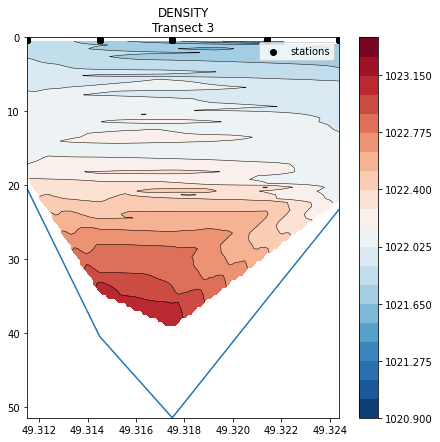

In [11]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="RdBu_r")
plt.colorbar(boundaries=np.linspace(Dmin, Dmax, 21))
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('DENSITY\nTransect 3')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

# #SALINITY
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect 3')

# #TEMPERATURE
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect 3')

#### Transect 2

In [12]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T2']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T2']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T2']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T2']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T2']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T2']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T2']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T2']))

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


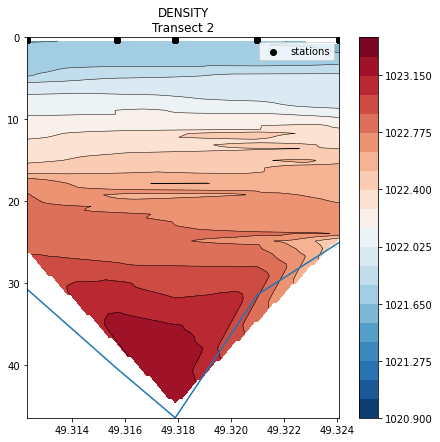

In [13]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="RdBu_r")
plt.colorbar(boundaries=np.linspace(Dmin, Dmax, 21))
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('DENSITY\nTransect 2')

plt.scatter(lat,top, c='k', label='stations')
plt.legend()

#SALINITY 
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect 2')

# #TEMPERATURE
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect 2')

#### Transect 2b

In [14]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T2b']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T2b']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T2b']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T2b']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T2b']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T2b']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T2b']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T2b']))

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


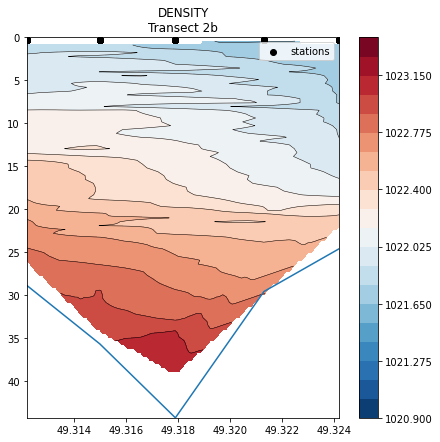

In [15]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="RdBu_r")
plt.colorbar(boundaries=np.linspace(Dmin, Dmax, 21))
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('DENSITY\nTransect 2b')

plt.scatter(lat,top, c='k', label='stations')
plt.legend()

# #SALINITY
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect 2b')

# #TEMPERATURE
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect 2b')

#### Transect 4

In [16]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T4']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T4']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T4']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T4']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T4']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T4']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T4']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T4']))

/home/rbeutel/anaconda3/envs/eosc573/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


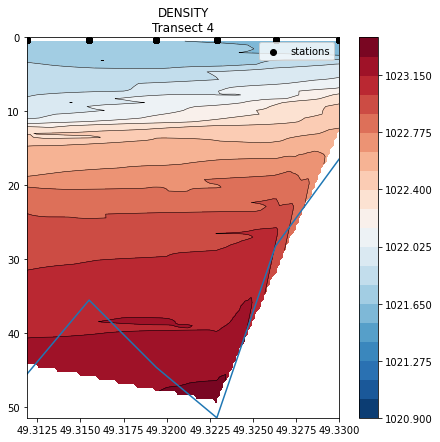

In [17]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="RdBu_r")
plt.colorbar(boundaries=np.linspace(Dmin, Dmax, 21))
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('DENSITY\nTransect 4')

plt.scatter(lat,top, c='k', label='stations')
plt.legend()

# #SALINITY
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect 4')

# #TEMPERATURE
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect 4')